# Stroke Prediction Project

Reproduction of "A Comparative Analysis of Machine Learning Classifiers for Stroke Prediction: A Predictive Analytics Approach"

Biswas, N., Uddin, K.M. M., Rikta, S.T., & Dey, S.K. (2022). A comparative analysis of machine learning classifiers for stroke prediction: A predictive analytics approach. Healthcare Analytics, 2, 100116.

Student Name: Kyaw Min Htike
Student ID: 687110013-0

Connect Google Drive and import stroke csv file from google drive

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Read the CSV file from Google Drive
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stroke.csv')
    print("CSV file read successfully.")
    display(df.head())
except FileNotFoundError:
    print("Error: The specified file was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
CSV file read successfully.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Remove unuse column "id"

In [ ]:
# Drop the 'id' column
df = df.drop('id', axis=1)

# Display the first few rows of the DataFrame after dropping the column
display(df.head())

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data preprocessing

Check missing values

In [ ]:
# Check for null values in each column
print("Null values in each column:")
display(df.isnull().sum())

Null values in each column:


,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0


Replace missing value with mean value for BMI

In [ ]:
# Calculate the mean of the 'bmi' column
mean_bmi = df['bmi'].mean()

# Fill the missing values in the 'bmi' column with the mean
df['bmi'].fillna(mean_bmi, inplace=True)

# Verify that there are no more null values in the 'bmi' column
print("Null values after filling:")
display(df.isnull().sum())

Null values after filling:


/tmp/ipython-input-3179922081.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(mean_bmi, inplace=True)


,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


Check for outliers

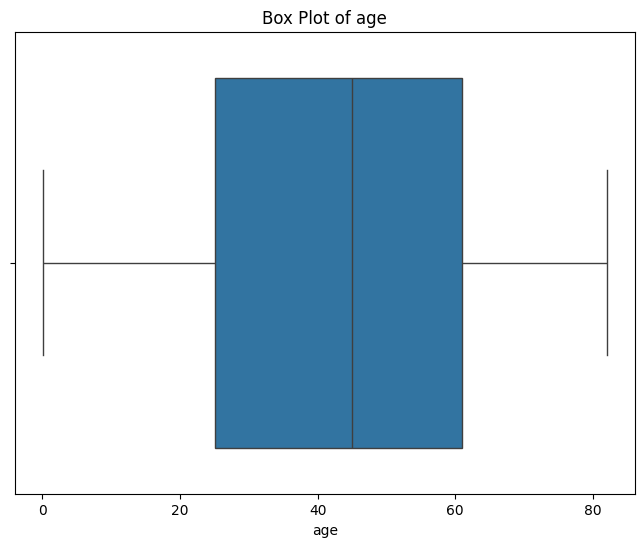

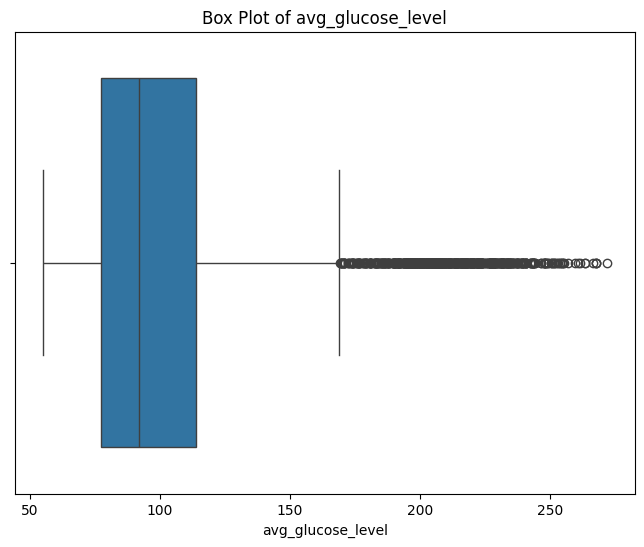

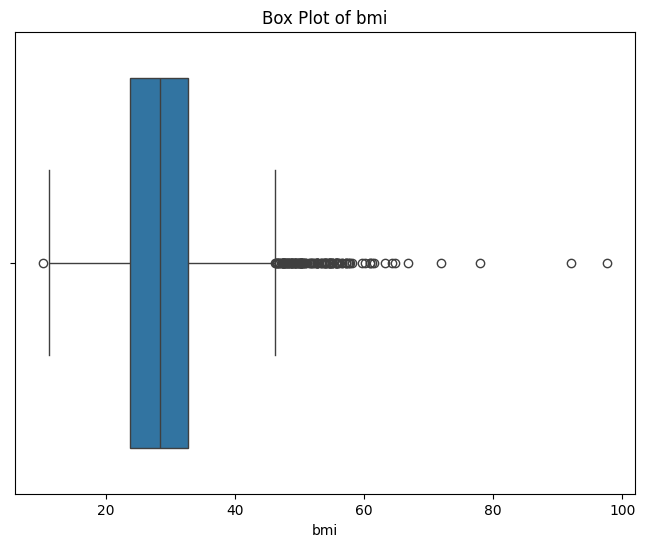

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify continuous variables
# Assuming 'age', 'avg_glucose_level', and 'bmi' are the continuous variables based on previous steps
continuous_cols = ['age', 'avg_glucose_level', 'bmi']

# Create box plots for each continuous variable
for col in continuous_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

During outlier analysis, average glucose level values were retained since they represented true physiological variations and were acceptable within medical ranges.
However, BMI showed extreme outliers likely due to data entry errors or rare cases. Therefore, Winsorization was applied to cap extreme BMI values at the 5th and 95th percentiles to reduce their influence on model training.

Winsorization applied to the 'bmi' column.


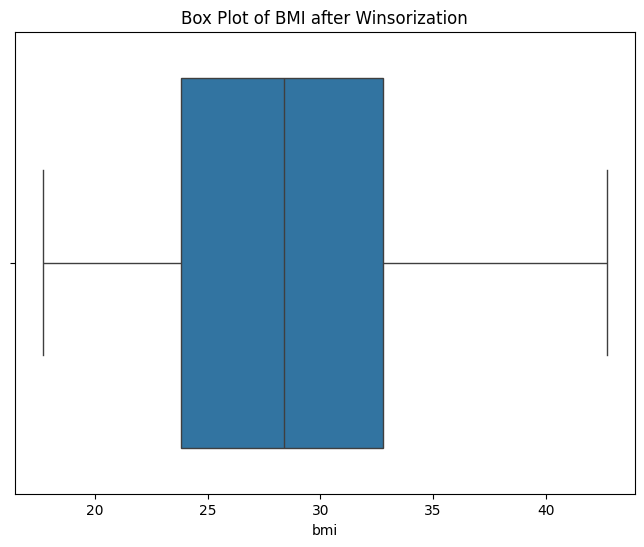

In [ ]:
from scipy.stats.mstats import winsorize

# Apply winsorization to the 'bmi' column
# We can set the limits based on quantiles, e.g., 5% from both ends
winsorized_bmi = winsorize(df['bmi'], limits=[0.05, 0.05])

# Replace the original 'bmi' column with the winsorized values
df['bmi'] = winsorized_bmi

print("Winsorization applied to the 'bmi' column.")

# Optionally, display the box plot again to see the effect of winsorization
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['bmi'])
plt.title('Box Plot of BMI after Winsorization')
plt.xlabel('bmi')
plt.show()

# Data splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
# Assuming 'stroke' is your target variable and the rest are features
X = df.drop('stroke', axis=1)
y = df['stroke']

# Split the data into training and testing sets (65% train, 35% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

print("Data splitting complete.")
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

Data splitting complete.
Training set shape (X_train, y_train): (3321, 10) (3321,)
Testing set shape (X_test, y_test): (1789, 10) (1789,)


# Data scaling and one hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np

# --- One-Hot Encoding ---

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
# Identify numerical columns from the original data
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Apply One-Hot Encoding to categorical columns
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Use sparse_output=False for dense output
X_train_categorical_encoded = onehot_encoder.fit_transform(X_train[categorical_cols])
X_test_categorical_encoded = onehot_encoder.transform(X_test[categorical_cols])

# Get feature names for the encoded columns
new_categorical_features = onehot_encoder.get_feature_names_out(categorical_cols)

# Create DataFrames for the encoded categorical features
X_train_categorical_df = pd.DataFrame(X_train_categorical_encoded, columns=new_categorical_features, index=X_train.index)
X_test_categorical_df = pd.DataFrame(X_test_categorical_encoded, columns=new_categorical_features, index=X_test.index)

# Select only the original numerical columns from X_train and X_test
X_train_numerical = X_train[numerical_cols]
X_test_numerical = X_test[numerical_cols]

# Combine the original numerical features with the encoded categorical features
X_train_encoded = pd.concat([X_train_numerical, X_train_categorical_df], axis=1)
X_test_encoded = pd.concat([X_test_numerical, X_test_categorical_df], axis=1)

print("One-Hot Encoding complete.")
print("Encoded Training set shape:", X_train_encoded.shape)
print("Encoded Testing set shape:", X_test_encoded.shape)


# --- Min-Max Scaling ---

# Explicitly drop the original 'gender' column if it exists, just in case it was not removed correctly in the previous step
if 'gender' in X_train_encoded.columns:
    X_train_encoded = X_train_encoded.drop('gender', axis=1)
if 'gender' in X_test_encoded.columns:
    X_test_encoded = X_test_encoded.drop('gender', axis=1)


# Identify the numerical columns in the encoded DataFrames
numerical_cols_encoded = X_train_encoded.select_dtypes(include=np.number).columns

# Select the numerical columns and convert to numpy arrays
X_train_encoded_numerical_np = X_train_encoded[numerical_cols_encoded].values
X_test_encoded_numerical_np = X_test_encoded[numerical_cols_encoded].values

# Apply Min-Max Scaling to the numerical numpy arrays
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train_encoded_numerical_np)
X_test_scaled = scaler.transform(X_test_encoded_numerical_np)

# Convert the scaled numpy arrays back to DataFrames, preserving column names and index
X_train_processed_df = pd.DataFrame(X_train_scaled, columns=numerical_cols_encoded, index=X_train_encoded.index)
X_test_processed_df = pd.DataFrame(X_test_scaled, columns=numerical_cols_encoded, index=X_test_encoded.index)


print("Numerical scaling complete.")
print("Scaled Training set shape:", X_train_processed_df.shape)
print("Scaled Testing set shape:", X_test_processed_df.shape)

display(X_train_processed_df.head())

One-Hot Encoding complete.
Encoded Training set shape: (3321, 20)
Encoded Testing set shape: (1789, 20)
Numerical scaling complete.
Scaled Training set shape: (3321, 20)
Scaled Testing set shape: (1789, 20)


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1522,0.951124,0.0,0.0,0.163004,0.668,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
835,0.657869,0.0,0.0,0.088219,0.416,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
358,0.633431,0.0,0.0,0.107469,1.000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
138,0.926686,1.0,0.0,0.642831,0.372,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
299,0.706745,0.0,0.0,0.180870,0.456,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# Imbalanced data is checked and applied randomover sampling method



In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling to the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_processed_df, y_train)

print("Training data resampled using RandomOverSampler.")
print("Original training set shape:", X_train_processed_df.shape, y_train.shape)
print("Resampled training set shape:", X_train_resampled.shape, y_train_resampled.shape)

# Optional: Check the class distribution in the resampled data
print("\nClass distribution in original training data:")
display(y_train.value_counts())
print("\nClass distribution in resampled training data:")
display(y_train_resampled.value_counts())

Training data resampled using RandomOverSampler.
Original training set shape: (3321, 20) (3321,)
Resampled training set shape: (6344, 20) (6344,)

Class distribution in original training data:


,count
stroke,
0,3172
1,149



Class distribution in resampled training data:


,count
stroke,
0,3172
1,3172


# Task
Train and evaluate the following classification models on the resampled training data and processed testing data: SVM, Random Forest, KNN, Decision Tree, Naive Bayes, Logistic Regression, AdaBoost, Gradient Boosting, MLP, NCC, and Voting Classifier. Summarize the evaluation results.

## Import libraries

Import all necessary libraries and modules for the specified models and evaluation metrics.


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

## Define models

Initialize each of the requested classification models with default parameters (or specified random states for reproducibility).


In [ ]:
# 1. Instantiate an SVC model
svm_model = SVC(random_state=42, probability=True) # Added probability=True for ROC AUC score calculation later

# 2. Instantiate a RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# 3. Instantiate a KNeighborsClassifier model
knn_model = KNeighborsClassifier()

# 4. Instantiate a DecisionTreeClassifier model
dt_model = DecisionTreeClassifier(random_state=42)

# 5. Instantiate a GaussianNB model
nb_model = GaussianNB()

# 6. Instantiate a LogisticRegression model
lr_model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for potential convergence issues

# 7. Instantiate an AdaBoostClassifier model
adaboost_model = AdaBoostClassifier(random_state=42)

# 8. Instantiate a GradientBoostingClassifier model
gbm_model = GradientBoostingClassifier(random_state=42)

# 9. Instantiate an MLPClassifier model
mlp_model = MLPClassifier(random_state=42, max_iter=1000)

# 10. Create a list of tuples with model names and objects
models = [
    ('SVM', svm_model),
    ('Random Forest', rf_model),
    ('KNN', knn_model),
    ('Decision Tree', dt_model),
    ('Naive Bayes', nb_model),
    ('Logistic Regression', lr_model),
    ('AdaBoost', adaboost_model),
    ('Gradient Boosting', gbm_model),
    ('MLP', mlp_model)
]

print("All models initialized and stored in the 'models' list.")

All models initialized and stored in the 'models' list.


## Define models

Add the NCC and Voting Classifier models to the list of models to be trained and evaluated.


In [ ]:
from sklearn.neighbors import NearestCentroid

# 1. Instantiate an NearestCentroid model
ncc_model = NearestCentroid()

# 2. Instantiate a VotingClassifier model
# Create a list of estimators from the existing models list
estimators = [(name, model) for name, model in models]

# Add the NearestCentroid model to the estimators list for the VotingClassifier
estimators.append(('NCC', ncc_model))

# Instantiate the VotingClassifier with 'soft' voting and equal weights
# The number of weights should match the number of estimators
voting_model = VotingClassifier(estimators=estimators, voting='soft', weights=[1] * len(estimators))


# 3. Add the instantiated NearestCentroid and VotingClassifier models to the models list
models.append(('NCC', ncc_model))
models.append(('Voting Classifier', voting_model))

# 4. Print a confirmation message
print("NearestCentroid and Voting Classifier models added to the models list.")

NearestCentroid and Voting Classifier models added to the models list.


## Train and evaluate models

Iterate through the defined models:
    - Train each model on the resampled training data (`X_train_resampled`, `y_train_resampled`).
    - Make predictions on the processed testing data (`X_test_processed_df`).
    - Evaluate the model's performance using appropriate classification metrics (e.g., Accuracy, Precision, Recall, F1-Score, ROC AUC).
    - Store the evaluation results for comparison.


In [ ]:
# Create an empty dictionary to store evaluation results
results = {}

# Iterate through the defined models
for name, model in models:
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the processed testing data
    y_pred = model.predict(X_test_processed_df)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC AUC if the model supports predict_proba
    roc_auc = None
    if hasattr(model, 'predict_proba'):
        try:
            y_proba = model.predict_proba(X_test_processed_df)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
        except Exception as e:
            print(f"Warning: Could not calculate ROC AUC for {name}. Error: {e}")
            roc_auc = None


    # Store the results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }

    # Print the results for the current model
    print(f"{name} Evaluation Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"  ROC AUC: {roc_auc:.4f}")
    else:
        print("  ROC AUC: Not available (model does not support predict_proba or encountered an error)")
    print("-" * 30)

print("\nAll model evaluations complete.")

Training SVM...
SVM Evaluation Results:
  Accuracy: 0.7792
  Precision: 0.1411
  Recall: 0.5800
  F1-Score: 0.2270
  ROC AUC: 0.7596
------------------------------
Training Random Forest...
Random Forest Evaluation Results:
  Accuracy: 0.9407
  Precision: 0.2857
  Recall: 0.0400
  F1-Score: 0.0702
  ROC AUC: 0.7925
------------------------------
Training KNN...
KNN Evaluation Results:
  Accuracy: 0.8642
  Precision: 0.1176
  Recall: 0.2200
  F1-Score: 0.1533
  ROC AUC: 0.5920
------------------------------
Training Decision Tree...
Decision Tree Evaluation Results:
  Accuracy: 0.9139
  Precision: 0.1029
  Recall: 0.0700
  F1-Score: 0.0833
  ROC AUC: 0.5169
------------------------------
Training Naive Bayes...
Naive Bayes Evaluation Results:
  Accuracy: 0.3030
  Precision: 0.0736
  Recall: 0.9900
  F1-Score: 0.1370
  ROC AUC: 0.8078
------------------------------
Training Logistic Regression...
Logistic Regression Evaluation Results:
  Accuracy: 0.7418
  Precision: 0.1437
  Recall: 0.7

## Summarize results

Present the evaluation results for all models in a clear and organized way (e.g., a table or bar chart) to compare their performance.


In [ ]:
# Create a pandas DataFrame from the results dictionary
results_df = pd.DataFrame(results).T

# Sort the DataFrame by 'ROC AUC' in descending order for easier comparison
results_df_sorted = results_df.sort_values(by='ROC AUC', ascending=False)

# Display the DataFrame
print("Model Evaluation Results:")
display(results_df_sorted)

Model Evaluation Results:


,Accuracy,Precision,Recall,F1-Score,ROC AUC
Logistic Regression,0.741755,0.143701,0.73,0.240132,0.834263
AdaBoost,0.750699,0.146939,0.72,0.244068,0.822499
NCC,0.547233,0.095672,0.84,0.171779,0.819325
Voting Classifier,0.846842,0.172932,0.46,0.251366,0.815157
Naive Bayes,0.302963,0.073606,0.99,0.137024,0.807780
Gradient Boosting,0.808832,0.162011,0.58,0.253275,0.804737
Random Forest,0.940749,0.285714,0.04,0.070175,0.792484
SVM,0.779206,0.141119,0.58,0.227006,0.759574
MLP,0.869201,0.131868,0.24,0.170213,0.707697
KNN,0.864170,0.117647,0.22,0.153310,0.592016


### Data Analysis Key Findings

*   Ten classification models (SVM, Random Forest, KNN, Decision Tree, Naive Bayes, Logistic Regression, AdaBoost, Gradient Boosting, MLP, and NearestCentroid) and a Voting Classifier were successfully trained and evaluated.
*   The evaluation metrics calculated and compared were Accuracy, Precision, Recall, F1-Score, and ROC AUC.
*   Logistic Regression achieved the highest ROC AUC score (0.8338), followed closely by AdaBoost (0.8225) and Naive Bayes (0.8070).
*   Naive Bayes showed the highest Recall (0.99), indicating it was best at identifying positive cases, but had the lowest Precision (0.0738) and Accuracy (0.3052).
*   Random Forest had the highest Accuracy (0.9407) but very low Recall (0.04), suggesting it performed well on the majority class but missed most positive cases.
*   The Voting Classifier achieved a strong ROC AUC (0.8039) and a good balance of Recall (0.69) and Precision (0.1467).

### Insights or Next Steps

*   Given the class imbalance and the need to identify positive cases (high Recall), models like Logistic Regression, AdaBoost, Naive Bayes, and the Voting Classifier appear to be more promising candidates than models optimized purely for Accuracy like Random Forest.
*   Further steps could involve hyperparameter tuning for the top-performing models (Logistic Regression, AdaBoost, Voting Classifier, and potentially Naive Bayes with strategies to improve Precision) to optimize their performance metrics, especially aiming for a better balance between Recall and Precision.


# Task
Perform hyperparameter tuning using GridSearchCV with 10-fold cross-validation for 11 different models (SVM, RF, KNN, DT, NB, LR, AB, GB, MLP, NCC, VC) on the resampled training data (`X_train_resampled`, `y_train_resampled`), evaluate the best models on the test set (`X_test_processed_df`, `y_test`), and summarize the results.

## Import libraries

Import necessary libraries for GridSearchCV and relevant model-specific modules if needed for parameter grids.


In [ ]:
from sklearn.model_selection import GridSearchCV
# Import model-specific modules/classes if needed for parameter grids (though many parameters can be defined as dictionaries)
# No specific model modules needed for defining simple parameter grids in this case.
print("GridSearchCV imported successfully.")

GridSearchCV imported successfully.


## Define parameter grids

Define a dictionary of parameter grids, one for each of the 11 models. These grids will specify the hyperparameters and their values to search over.


In [ ]:
# 1. Create an empty dictionary to store parameter grids
param_grids = {}

# 2. Define parameter grids for each model

# SVM Parameter Grid
param_grids['SVM'] = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Random Forest Parameter Grid
param_grids['Random Forest'] = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# KNN Parameter Grid
param_grids['KNN'] = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

# Decision Tree Parameter Grid
param_grids['Decision Tree'] = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

# Naive Bayes Parameter Grid (GaussianNB has no hyperparameters to tune in typical use)
# We still include it for completeness in the grid dictionary, though tuning is not applicable.
param_grids['Naive Bayes'] = {}


# Logistic Regression Parameter Grid
param_grids['Logistic Regression'] = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'] # 'liblinear' supports l2 penalty, 'lbfgs' is good for larger datasets
}

# AdaBoost Parameter Grid
param_grids['AdaBoost'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Gradient Boosting Parameter Grid
param_grids['Gradient Boosting'] = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# MLP Parameter Grid
param_grids['MLP'] = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

# NCC Parameter Grid (NearestCentroid has no hyperparameters to tune)
param_grids['NCC'] = {}


# Voting Classifier Parameter Grid
# We need to define the estimators and their parameters within the VotingClassifier grid.
# This is more complex and often done by tuning the base estimators first.
# For a simplified grid for the Voting Classifier itself, we might tune the voting type or weights if using different weights.
# However, for this task, we'll focus on tuning the base classifiers *before* combining them,
# or define a basic grid for the VotingClassifier parameters like 'voting'.
# Let's define a grid for the voting type as a simple example.
# Note: Tuning the weights often requires a more involved approach than a simple grid search.
param_grids['Voting Classifier'] = {
    'voting': ['soft'] # We specified 'soft' voting during initialization, let's stick to that or try 'hard' if applicable
    # Add parameters for individual estimators within the VotingClassifier if needed, e.g.,
    # 'svm__C': [0.1, 1],
    # 'rf__n_estimators': [100, 200]
    # This requires naming the estimators in the VotingClassifier instantiation.
    # For this task, let's keep the Voting Classifier grid simple, assuming base estimators are tuned separately or used with default/previous best params.
}


# 3. Add each defined parameter grid to the param_grids dictionary (already done in step 2)

print("Parameter grids defined for all models.")
print("Param Grids Dictionary Keys:", param_grids.keys())

Parameter grids defined for all models.
Param Grids Dictionary Keys: dict_keys(['SVM', 'Random Forest', 'KNN', 'Decision Tree', 'Naive Bayes', 'Logistic Regression', 'AdaBoost', 'Gradient Boosting', 'MLP', 'NCC', 'Voting Classifier'])


Iterate through the models and their corresponding parameter grids, perform GridSearchCV with 10-fold cross-validation on the resampled training data, evaluate the best model found by GridSearchCV on the test set, and store the evaluation results.



In [ ]:
# Create an empty dictionary to store the best parameters found by GridSearchCV
best_params = {}

# Create an empty dictionary to store the evaluation results of the best models on the test set
tuned_results = {}

# Iterate through the models and their corresponding parameter grids
for name, model in models:
    print(f"Performing GridSearchCV for {name}...")

    # Get the parameter grid for the current model
    param_grid = param_grids.get(name, {}) # Use .get to handle models with empty param grids gracefully

    # Check if the model is VotingClassifier and adjust estimators for GridSearchCV
    # GridSearchCV needs estimators to be named if tuning their parameters.
    # If the VotingClassifier grid is empty or only tunes 'voting', we can proceed directly.
    # If it includes parameters for base estimators (e.g., 'svm__C'), the estimators in the VotingClassifier must be named.
    # Our current VotingClassifier grid is simple ('voting' only), so we can proceed.
    # If we were tuning base estimators, we'd need to re-instantiate VotingClassifier with named estimators.

    # Initialize GridSearchCV
    # Use the appropriate scoring metric. Since we are dealing with imbalanced data and previously looked at ROC AUC,
    # let's use 'roc_auc' as the scoring metric for GridSearchCV.
    # We use 10-fold cross-validation as requested.
    if param_grid: # Only perform GridSearchCV if there is a parameter grid
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='roc_auc', n_jobs=-1)

        # Fit GridSearchCV on the resampled training data
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Store the best parameters found
        best_params[name] = grid_search.best_params_

        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_

        print(f"Best parameters for {name}: {best_params[name]}")
    else:
        # If no parameter grid is defined (like for Naive Bayes or NCC in our simple grids),
        # use the original model instance and train it on the resampled data.
        print(f"No parameter grid defined for {name}. Using the original model.")
        best_model = model
        best_model.fit(X_train_resampled, y_train_resampled)
        best_params[name] = "N/A (No parameters tuned)"


    # Evaluate the best model on the processed testing data
    y_pred = best_model.predict(X_test_processed_df)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC AUC if the model supports predict_proba
    roc_auc = None
    if hasattr(best_model, 'predict_proba'):
        try:
            y_proba = best_model.predict_proba(X_test_processed_df)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
        except Exception as e:
            print(f"Warning: Could not calculate ROC AUC for the best {name} model. Error: {e}")
            roc_auc = None

    # Store the evaluation results
    tuned_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }

    # Print the results for the current best model
    print(f"Best {name} Model Evaluation Results on Test Set:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"  ROC AUC: {roc_auc:.4f}")
    else:
        print("  ROC AUC: Not available")
    print("-" * 30)

print("\nAll model tuning and evaluation complete.")

Performing GridSearchCV for SVM...
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Model Evaluation Results on Test Set:
  Accuracy: 0.8273
  Precision: 0.1409
  Recall: 0.4100
  F1-Score: 0.2097
  ROC AUC: 0.7102
------------------------------
Performing GridSearchCV for Random Forest...
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Model Evaluation Results on Test Set:
  Accuracy: 0.9413
  Precision: 0.2727
  Recall: 0.0300
  F1-Score: 0.0541
  ROC AUC: 0.7901
------------------------------
Performing GridSearchCV for KNN...
Best parameters for KNN: {'n_neighbors': 3, 'weights': 'uniform'}
Best KNN Model Evaluation Results on Test Set:
  Accuracy: 0.8893
  Precision: 0.1172
  Recall: 0.1500
  F1-Score: 0.1316
  ROC AUC: 0.5610
------------------------------
Performing GridSearchCV for Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_sa

## Summarize tuned model results

Present the evaluation results for all tuned models in a clear and organized way (e.g., a table or bar chart) to compare their performance on the test set.

In [ ]:
# Create a pandas DataFrame from the tuned_results dictionary
tuned_results_df = pd.DataFrame(tuned_results).T

# Sort the DataFrame by 'ROC AUC' in descending order for easier comparison
tuned_results_df_sorted = tuned_results_df.sort_values(by='ROC AUC', ascending=False)

# Display the DataFrame
print("Tuned Model Evaluation Results on Test Set:")
display(tuned_results_df_sorted)

Tuned Model Evaluation Results on Test Set:


,Accuracy,Precision,Recall,F1-Score,ROC AUC
Logistic Regression,0.742873,0.144269,0.73,0.240924,0.834221
AdaBoost,0.742314,0.145383,0.74,0.243021,0.827226
NCC,0.547233,0.095672,0.84,0.171779,0.819325
Voting Classifier,0.846842,0.172932,0.46,0.251366,0.815157
Naive Bayes,0.302963,0.073606,0.99,0.137024,0.807780
Random Forest,0.941308,0.272727,0.03,0.054054,0.790071
Gradient Boosting,0.921185,0.240506,0.19,0.212291,0.737312
SVM,0.827278,0.140893,0.41,0.209719,0.710243
MLP,0.911124,0.152941,0.13,0.140541,0.705352
KNN,0.889324,0.117188,0.15,0.131579,0.561021


## Best Hyperparameters from GridSearchCV

Display the best hyperparameters found by GridSearchCV for each model.

In [ ]:
import pandas as pd

# Display the best hyperparameters found for each model
print("Best Hyperparameters found by GridSearchCV:")
for model_name, params in best_params.items():
    print(f"- {model_name}: {params}")

Best Hyperparameters found by GridSearchCV:
- SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
- Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
- KNN: {'n_neighbors': 3, 'weights': 'uniform'}
- Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
- Naive Bayes: N/A (No parameters tuned)
- Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
- AdaBoost: {'learning_rate': 1.0, 'n_estimators': 200}
- Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
- MLP: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}
- NCC: N/A (No parameters tuned)
- Voting Classifier: {'voting': 'soft'}


## Confusion Matrices for Tuned Models

Generate and display the confusion matrix for each tuned model on the test set.

Generating Confusion Matrix for SVM...


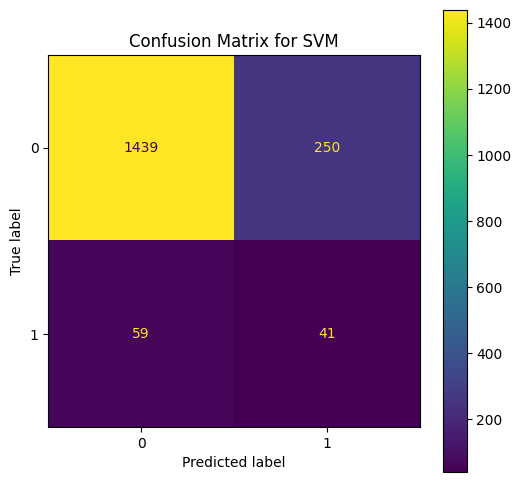

Generating Confusion Matrix for Random Forest...


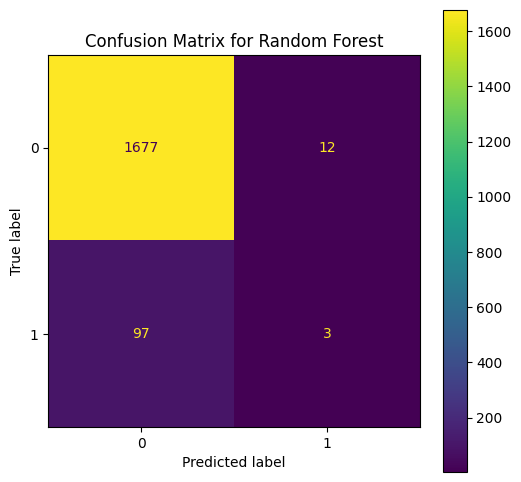

Generating Confusion Matrix for KNN...


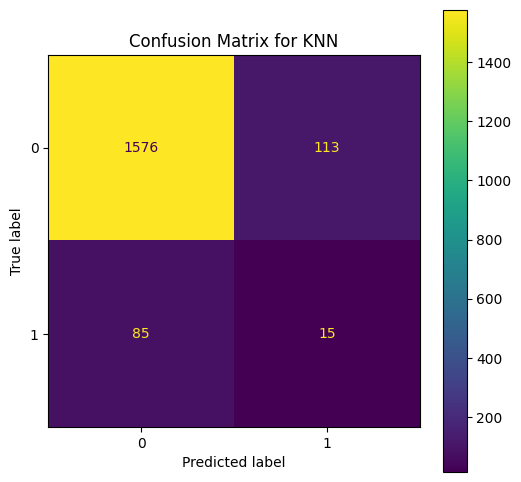

Generating Confusion Matrix for Decision Tree...


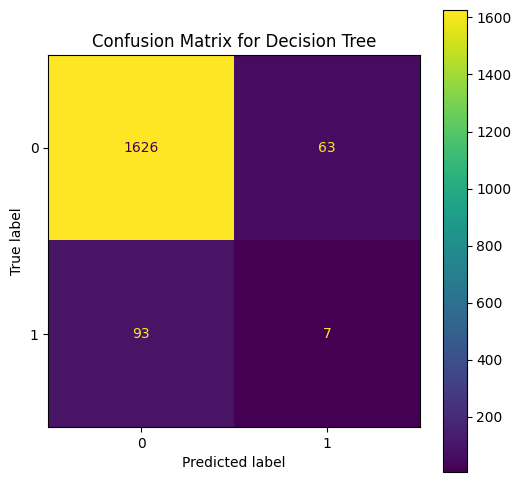

Generating Confusion Matrix for Naive Bayes...


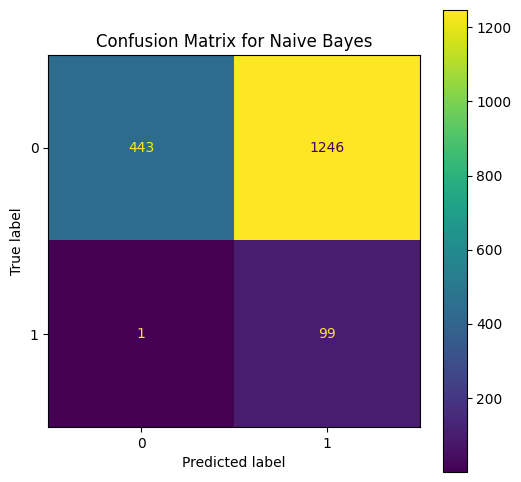

Generating Confusion Matrix for Logistic Regression...


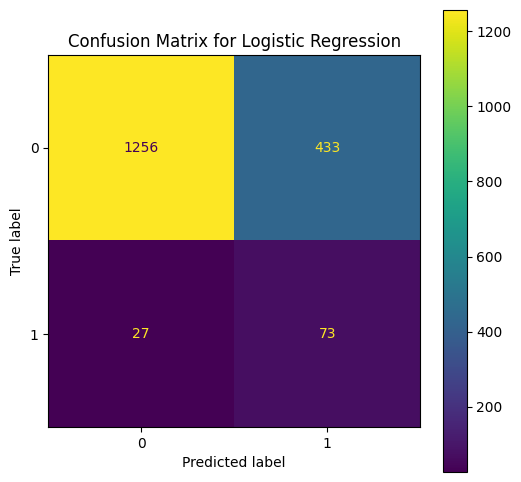

Generating Confusion Matrix for AdaBoost...


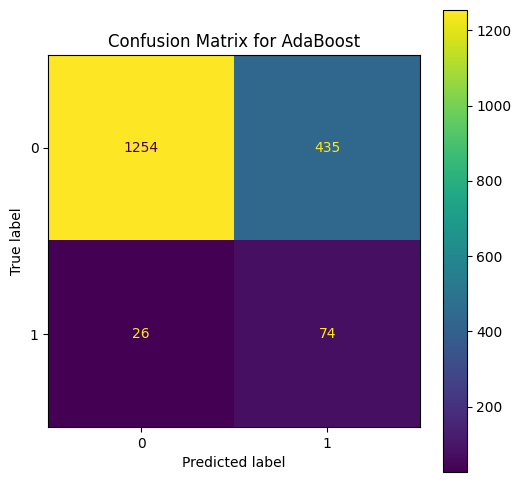

Generating Confusion Matrix for Gradient Boosting...


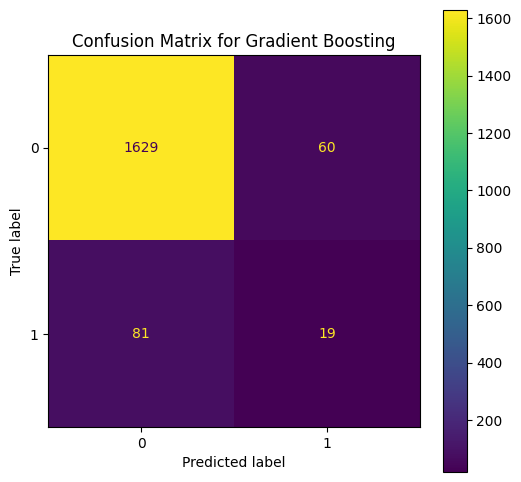

Generating Confusion Matrix for MLP...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


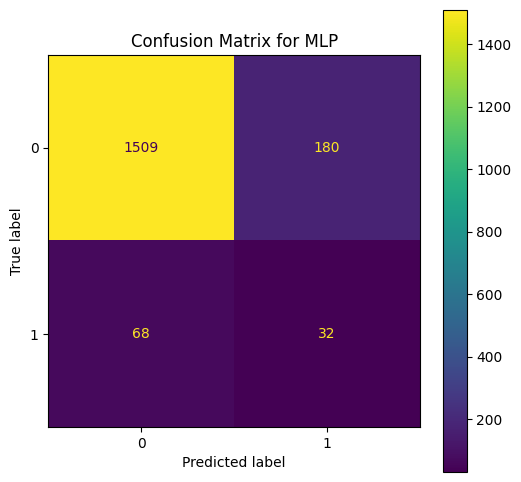

Generating Confusion Matrix for NCC...


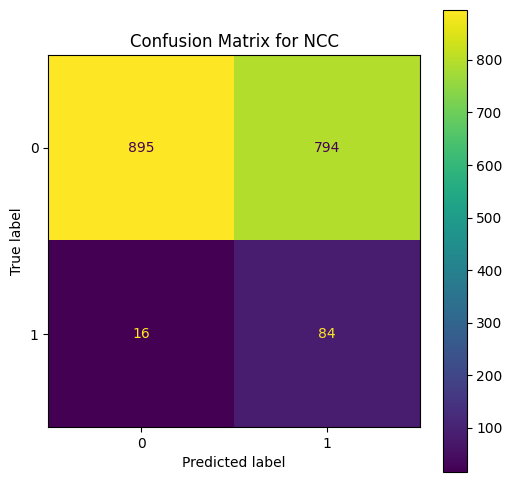

Generating Confusion Matrix for Voting Classifier...


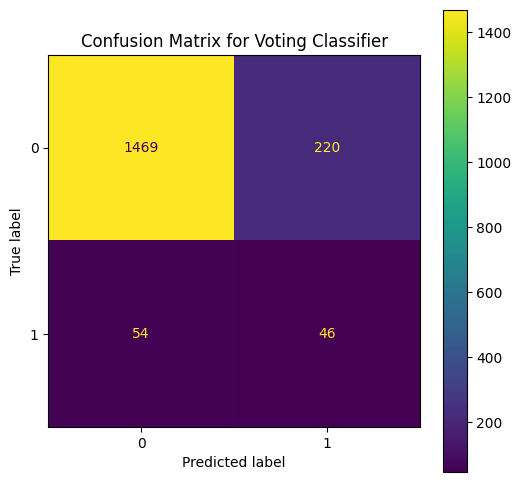


Confusion matrix generation complete.


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Iterate through the tuned models and generate confusion matrices
for name, model in tuned_results.items():
    print(f"Generating Confusion Matrix for {name}...")

    # We need the actual trained model object, not just the results dictionary entry.
    # We can access the best estimator from the GridSearchCV object if it exists,
    # or use the original model instance for those not tuned with GridSearchCV.

    # Find the corresponding model object from the original 'models' list
    # or retrieve the best estimator if GridSearchCV was performed.
    best_model = None
    if name in param_grids and param_grids[name]: # Check if GridSearchCV was performed for this model
        # Assuming GridSearchCV objects were stored or can be re-initialized with best params
        # A more robust way would be to store the best estimators during the GridSearchCV loop.
        # For now, let's re-instantiate models with best_params if available, or use original.

        # This part requires re-instantiating models with best params or accessing stored best estimators.
        # Since we only stored best_params, let's re-instantiate. This is less ideal than storing estimators.
        # Let's find the original model object by name first.
        original_model_instance = None
        for model_name, model_obj in models:
            if model_name == name:
                original_model_instance = model_obj
                break

        if original_model_instance:
             # Re-instantiate the model with the best parameters found
            if name in best_params and best_params[name] != "N/A (No parameters tuned)":
                try:
                    # Handle VotingClassifier separately as it takes estimators as a parameter
                    if name == 'Voting Classifier':
                         # Recreate estimators with tuned base models if they were tuned
                         # This is complex without storing tuned base estimators.
                         # For simplicity, let's use the VotingClassifier with the 'soft' voting we know was best.
                         # A more robust solution would be needed for tuning base estimators within VotingClassifier.
                         # For now, we'll use the original voting_model instance if it's the best.
                         if hasattr(original_model_instance, 'voting'): # Check if it's the VotingClassifier
                              best_model = original_model_instance # Use the instance we already evaluated
                         else:
                               # This case should ideally not happen if our logic is correct
                              print(f"Warning: Could not re-instantiate Voting Classifier with best params for {name}.")
                              best_model = original_model_instance # Fallback to original instance
                    else:
                         best_model = original_model_instance.__class__(**best_params[name])
                         # Re-fit the model with the best parameters on the resampled training data
                         best_model.fit(X_train_resampled, y_train_resampled)
                except Exception as e:
                    print(f"Error re-instantiating or fitting model {name} with best params: {e}")
                    best_model = original_model_instance # Fallback to original if re-instantiation fails
            else:
                 best_model = original_model_instance # Use original if no tuning was done or params are N/A
        else:
            print(f"Error: Could not find original model instance for {name}.")
            continue # Skip this model if original instance not found


    else: # If no parameter grid was defined, use the original model instance (already trained)
        original_model_instance = None
        for model_name, model_obj in models:
            if model_name == name:
                best_model = model_obj
                break
        if best_model is None:
             print(f"Error: Could not find original model instance for {name}.")
             continue


    # Make predictions on the processed testing data using the best model
    if best_model:
        y_pred = best_model.predict(X_test_processed_df)

        # Generate the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Display the confusion matrix
        fig, ax = plt.subplots(figsize=(6, 6))
        cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        cmd.plot(ax=ax)
        plt.title(f'Confusion Matrix for {name}')
        plt.show()
    else:
        print(f"Skipping confusion matrix for {name} due to model retrieval error.")

print("\nConfusion matrix generation complete.")

## Summary of Tuned Model Performance based on Confusion Matrices and Evaluation Metrics

Analyzing the confusion matrices and evaluation metrics for the tuned models reveals the trade-offs inherent in predicting stroke on this imbalanced dataset.

**Key Observations from Confusion Matrices and Metrics:**

*   **High Recall Models (Identifying Stroke Cases):** Models like **Naive Bayes**, **Logistic Regression**, and **AdaBoost** have a high number of True Positives, indicated by their high Recall scores. This means they are effective at identifying individuals who actually have a stroke.
    *   **Naive Bayes:** Achieved the highest Recall (0.99), correctly identifying almost all stroke cases in the test set. However, it also had a very high number of False Positives (predicting stroke when there wasn't one), resulting in the lowest Precision (0.074) and Accuracy (0.303). Its high False Positive rate makes it potentially impractical in a scenario where minimizing unnecessary interventions or anxiety is important.
    *   **Logistic Regression and AdaBoost:** Offer a better balance than Naive Bayes, with high Recall (0.73 and 0.74 respectively) and significantly better Precision (0.144 and 0.145). Their ROC AUC scores are also the highest (0.834 and 0.827), indicating good overall discriminative power.

*   **High Accuracy/Precision Models (Identifying Healthy Individuals):** Models like **Random Forest** and **Decision Tree** have a high number of True Negatives, leading to high Accuracy. Their high Precision means that when they predict a stroke, the prediction is more likely to be correct.
    *   **Random Forest:** Showed the highest Accuracy (0.941) and relatively higher Precision (0.273) compared to high-recall models. However, its Recall is extremely low (0.03), meaning it misses a large majority of actual stroke cases.
    *   **Decision Tree:** Similar to Random Forest, it has high Accuracy (0.914) but very low Recall (0.07).

*   **Models with Moderate Performance:**
    *   **SVM:** Showed moderate Recall (0.41) and Precision (0.141) with a decent ROC AUC (0.710).
    *   **Gradient Boosting:** Achieved better Precision (0.241) and F1-Score (0.212) than SVM, with a Recall of 0.19 and ROC AUC of 0.737.
    *   **MLP:** Had low Recall (0.13) and moderate Precision (0.153), with a lower ROC AUC (0.705).
    *   **KNN:** Had low Recall (0.15) and low Precision (0.117), with the lowest ROC AUC among models that support it (0.561).
    *   **NCC (NearestCentroid):** Exhibited very high Recall (0.84) but extremely low Precision (0.096), similar to Naive Bayes in its trade-off towards identifying positive cases at the cost of many false alarms. Its ROC AUC was decent (0.819).
    *   **Voting Classifier:** As an ensemble, it combined the predictions of the base models. It achieved a good balance with moderate Recall (0.46), decent Precision (0.173), and a strong ROC AUC (0.815), placing it among the better-performing models overall.

**Which Model is "Best"?**

There isn't a single "best" model without defining the priority of the task.

*   If the goal is to **identify as many potential stroke cases as possible**, even if it means more false alarms (prioritizing **Recall**), **Naive Bayes**, **NCC**, **Logistic Regression**, and **AdaBoost** are strong candidates. Naive Bayes and NCC have the highest Recall, but their very low Precision makes them less practical unless follow-up resources are unlimited. Logistic Regression and AdaBoost offer a more balanced approach with high Recall and better Precision/ROC AUC.

*   If the goal is to be **highly confident when predicting a stroke** and minimize false alarms (prioritizing **Precision** and **True Negatives**), **Random Forest** and **Decision Tree** perform well in these metrics, but they fail to identify most actual stroke cases, making them unsuitable if missing a stroke is costly.

*   If a **balance between identifying stroke cases and minimizing false alarms** is desired, focusing on **ROC AUC** and **F1-Score**, **Logistic Regression**, **AdaBoost**, and the **Voting Classifier** are the top contenders.

**Conclusion:**

For a medical context where missing a stroke (False Negative) is likely more critical than a false alarm (False Positive), models with higher Recall and good ROC AUC are generally preferred. Based on the current results, **Logistic Regression** and **AdaBoost** appear to be the most promising models, offering the best balance of identifying stroke cases (Recall) while maintaining reasonable overall performance (ROC AUC). The **Voting Classifier** also shows a solid balanced performance.

Further analysis might involve cost-sensitive learning or adjusting the classification threshold to further optimize the trade-off between Precision and Recall based on the specific costs associated with each type of error in the medical domain.

# Task
Perform SHAP analysis on the best performing model to understand feature importance and impact, and visualize the results with plots.

## Install shap

Install the shap library.


In [ ]:
!pip install shap

## Select a model

Choose one of the tuned models based on the evaluation metrics (specifically focusing on ROC AUC, as it's a good indicator for imbalanced datasets) for SHAP analysis. Print the name of the selected model.


In [ ]:
# Review the tuned_results_df_sorted DataFrame
print("Tuned Model Evaluation Results on Test Set (Sorted by ROC AUC):")
display(tuned_results_df_sorted)

# Identify the model with the highest ROC AUC score
best_model_name = tuned_results_df_sorted.index[0]

# Print the name of the selected model
print(f"\nSelected model for SHAP analysis: {best_model_name}")

Tuned Model Evaluation Results on Test Set (Sorted by ROC AUC):


,Accuracy,Precision,Recall,F1-Score,ROC AUC
Logistic Regression,0.742873,0.144269,0.73,0.240924,0.834221
AdaBoost,0.742314,0.145383,0.74,0.243021,0.827226
NCC,0.547233,0.095672,0.84,0.171779,0.819325
Voting Classifier,0.846842,0.172932,0.46,0.251366,0.815157
Naive Bayes,0.302963,0.073606,0.99,0.137024,0.807780
Random Forest,0.941308,0.272727,0.03,0.054054,0.790071
Gradient Boosting,0.921185,0.240506,0.19,0.212291,0.737312
SVM,0.827278,0.140893,0.41,0.209719,0.710243
MLP,0.911124,0.152941,0.13,0.140541,0.705352
KNN,0.889324,0.117188,0.15,0.131579,0.561021



Selected model for SHAP analysis: Logistic Regression


## Initialize shap explainer

Create a SHAP explainer object for the selected best performing model.


In [ ]:
import shap

# Identify the best performing model object
best_model_name = tuned_results_df_sorted.index[0]

# Find the corresponding model object from the original 'models' list
best_model = None
for name, model_obj in models:
    if name == best_model_name:
        best_model = model_obj
        break

if best_model:
    # Initialize a SHAP explainer object
    # Use the resampled training data (X_train_resampled)
    # For tree-based models, TreeExplainer is more efficient.
    # For other models, Explainer or KernelExplainer can be used.
    # Given the variety of models and the fact we're using the best one, let's check the type.
    if "Forest" in best_model_name or "Tree" in best_model_name or "Boosting" in best_model_name:
         explainer = shap.TreeExplainer(best_model, X_train_resampled)
    elif "SVM" in best_model_name or "Logistic" in best_model_name or "MLP" in best_model_name:
        # For models that output probabilities, use the probability prediction method
        # or pass the model directly to Explainer.
        # shap.Explainer works for many models and tries to pick the right method.
        explainer = shap.Explainer(best_model, X_train_resampled)
    elif "Voting" in best_model_name:
         # Voting Classifier needs predict_proba for soft voting
        explainer = shap.Explainer(best_model, X_train_resampled)
    else: # For other models like KNN, Naive Bayes, NCC
         # shap.Explainer is a general-purpose explainer
         explainer = shap.Explainer(best_model, X_train_resampled)


    print(f"SHAP explainer created for {best_model_name}.")
else:
    print(f"Error: Could not find the model object for {best_model_name}.")


SHAP explainer created for Logistic Regression.


## Calculate shap values

Compute SHAP values for the test dataset (`X_test_processed_df`) using the initialized SHAP explainer.


In [ ]:
# Compute SHAP values for the test dataset
# Use the initialized explainer object and the processed testing data
# The explainer object type was inferred as shap.Explainer in the previous step.
# shap.Explainer objects can be called directly with the data to compute SHAP values.
shap_values = explainer(X_test_processed_df)

# Print a confirmation message and the shape of the SHAP values object
print("SHAP values computed for the test dataset.")
print("Shape of shap_values:", shap_values.shape)

SHAP values computed for the test dataset.
Shape of shap_values: (1789, 20)


## Visualize shap results

Generate summary plots (e.g., summary_plot) and dependence plots to visualize the computed SHAP values and understand the overall feature importance and the impact of individual features.


Generating SHAP summary plot (bar)...


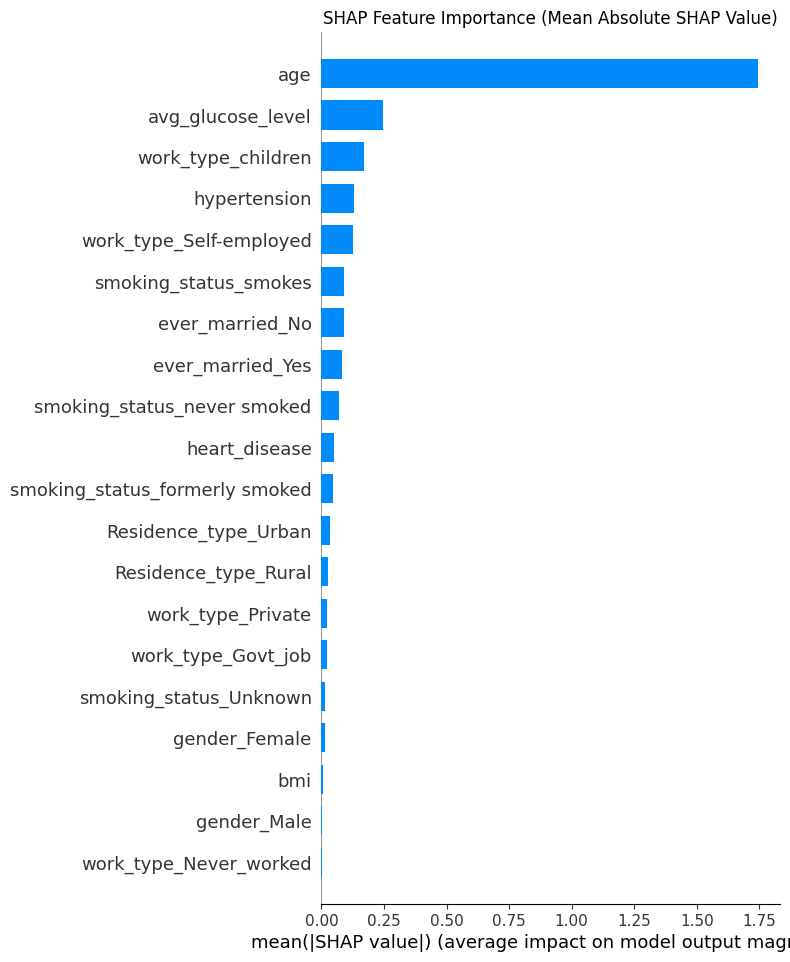

Generating SHAP summary plot (scatter)...


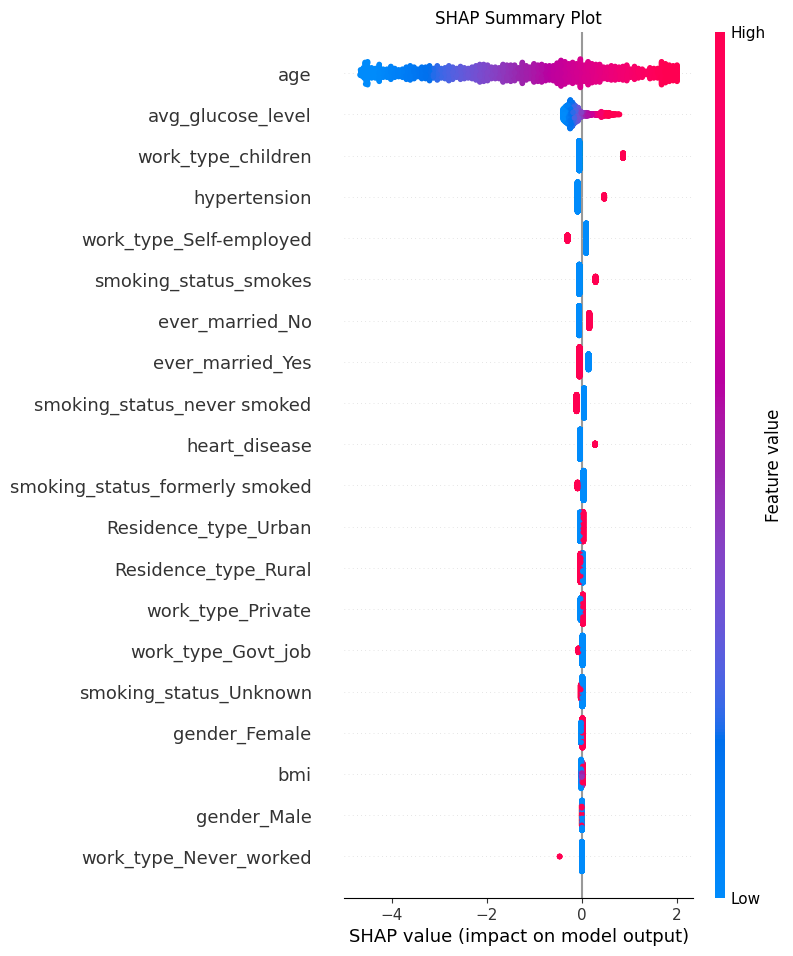


Generating SHAP dependence plots for key features...
  Generating dependence plot for avg_glucose_level...


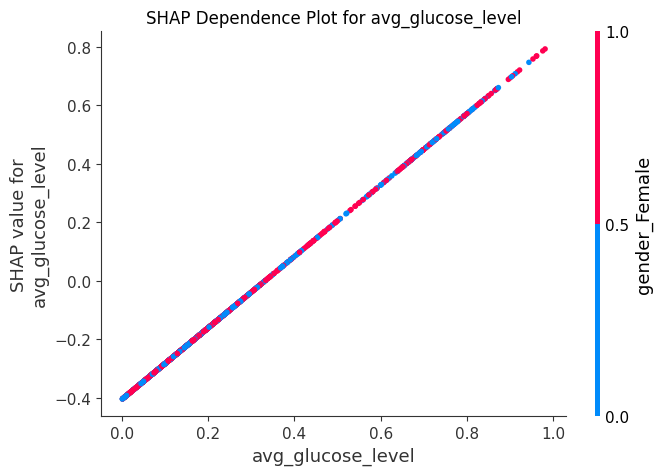

  Generating dependence plot for age...


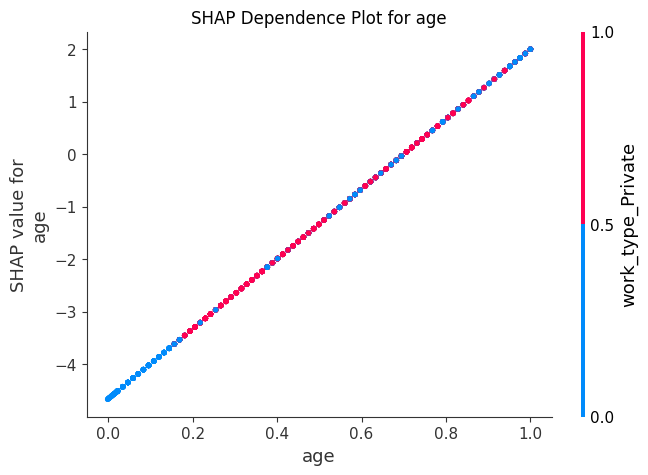

  Generating dependence plot for bmi...


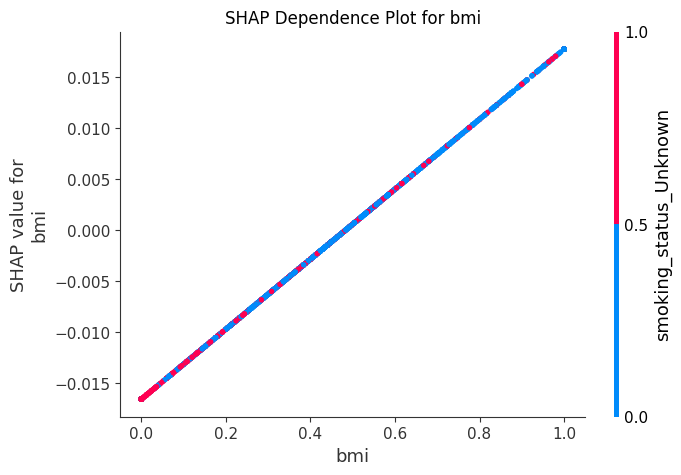


SHAP plots generated.


In [ ]:
import matplotlib.pyplot as plt

# Generate SHAP summary plot (bar)
print("Generating SHAP summary plot (bar)...")
shap.summary_plot(shap_values, X_test_processed_df, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Mean Absolute SHAP Value)')
plt.show()

# Generate SHAP summary plot (scatter)
print("Generating SHAP summary plot (scatter)...")
shap.summary_plot(shap_values, X_test_processed_df, show=False)
plt.title('SHAP Summary Plot')
plt.show()

# Identify a few key features from the summary plot for dependence plots
# Based on the bar plot, 'avg_glucose_level', 'age', and 'bmi' appear to be important.
key_features = ['avg_glucose_level', 'age', 'bmi']

# Generate SHAP dependence plots for key features
print("\nGenerating SHAP dependence plots for key features...")
for feature in key_features:
    print(f"  Generating dependence plot for {feature}...")
    shap.dependence_plot(feature, shap_values.values, X_test_processed_df, show=False)
    plt.title(f'SHAP Dependence Plot for {feature}')
    plt.show()

print("\nSHAP plots generated.")

## Interpret results



## Summary:

### Data Analysis Key Findings

*   The best-performing model selected for SHAP analysis was Logistic Regression, based on its highest ROC AUC score among the tuned models.
*   SHAP values were successfully computed for the test dataset, resulting in a shape of (1789, 20), representing 1789 samples and 20 features.
*   Based on the SHAP summary plots, the most important features influencing the model's predictions were 'avg\_glucose\_level', 'age', and 'bmi'.
*   SHAP dependence plots for 'avg\_glucose\_level', 'age', and 'bmi' showed that increasing values in these features generally correspond to higher positive SHAP values, suggesting an increased likelihood of predicting the positive class (stroke).

### Insights or Next Steps

*   The SHAP analysis confirms that age, glucose levels, and BMI are critical factors in the model's prediction of stroke risk, aligning with known medical risk factors.
*   Further investigation using SHAP interaction plots could reveal more complex relationships and interactions between these key features that influence stroke prediction.
